# Code to get biomarkers and graphics test 

## rutine to read and load the study

In [2]:
from bsp.core import load_study
from matplotlib import pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [14, 8]

In [3]:
study = load_study("data/prueba2.bsp")
print(study[1].angle)

30


In [ ]:
for test in study: 
    print(test, type(test))

In [ ]:
#pursuit = study[1]
#hor_p = pursuit.hor_channel.copy()
#stimuli_p = pursuit.hor_stimuli.copy()
#samples = len(hor_p)
#time = np.arange(samples)/1000.0


#plt.suptitle("señal de salida persecucion suave")

#plt.subplot(111)
#plt.title("señal horizontal")
#plt.plot(time, hor_p)
#plt.plot(time, stimuli_p)

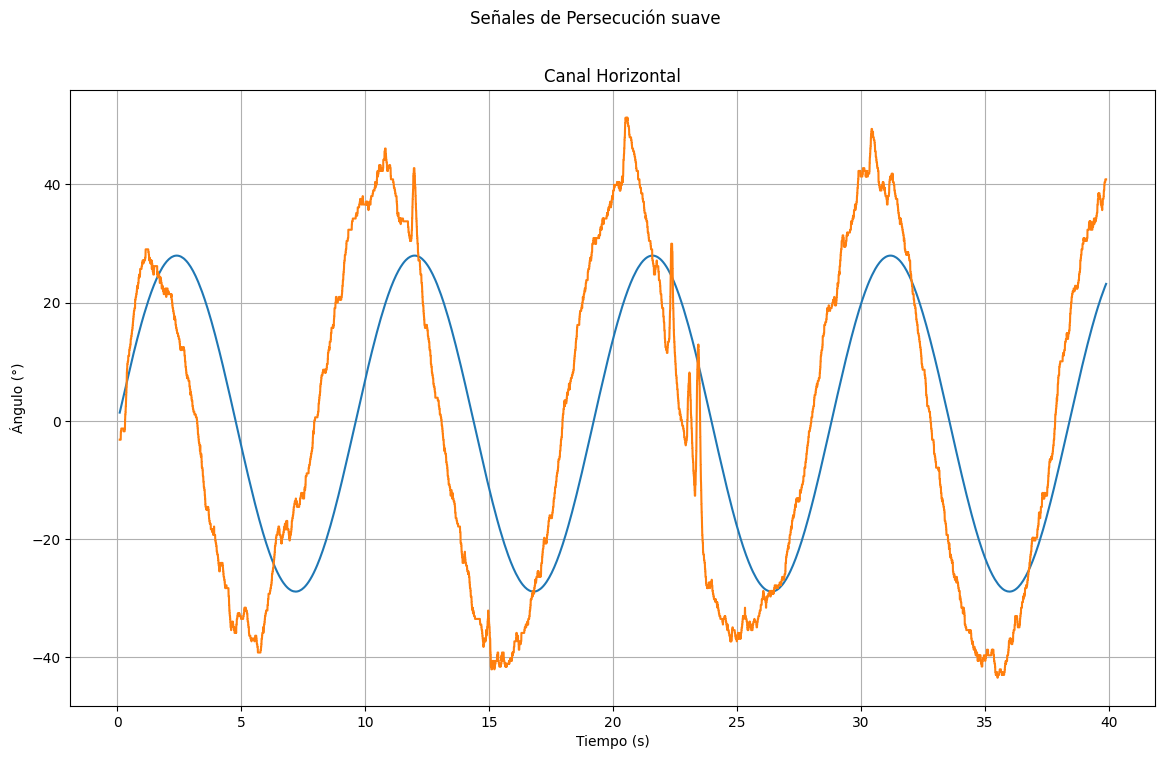

In [4]:
pursuit = study[1]
samples = len(pursuit.hor_channel)
time = np.arange(samples)/1000.0

#plt.suptitle("señal de salida persecucion suave")

#plt.subplot(111)
#plt.title("señal horizontal")
#plt.plot(time, hor_p)
#plt.plot(time, stimuli_p)

remove = 100

hor_raw = pursuit.hor_channel_raw
stim_raw = pursuit.hor_stimuli_raw


hor_p = pursuit.hor_channel.copy()[remove:-remove] *-1
amplitude = hor_p.max()-hor_p.min()
#amplitude

time = time[remove:-remove]

stimuli_p = pursuit.hor_stimuli.copy()[remove:-remove]
stimuli_p -= stimuli_p.mean()
stimuli_p *= (amplitude*2)

plt.suptitle("Señales de Persecución suave")

plt.title("Canal Horizontal")
plt.plot(time, stimuli_p)
plt.plot(time, hor_p)
plt.ylabel("Ángulo (°)")
plt.xlabel("Tiempo (s)")
plt.grid()

#plt.xlim(0, 6)
#plt.plot(time[5000], stimuli_p[5000]) #, 'ro', label='punto stimuli')
#plt.plot(time[3300], hor_p[3300]) #, 'bo', label='punto horizontal')
#plt.legend()


#plt.plot(time[15000], stimuli_p[15000], 'ro', label='punto stimuli')
#plt.plot(time[13925], hor_p[13925], 'bo', label='punto horizontal')
#plt.plot(time[12850], hor_p[12850], 'yo', label='punto horizontal')
#plt.plot(time[13411], hor_p[13411], 'go', label='punto horizontal')

#plt.plot(time[16500], stimuli_p[16500], 'ro', label='punto stimuli')
#plt.plot(time[15000], hor_p[15000], 'bo', label='punto horizontal')

#plt.plot(time[0], stimuli_p[0], 'ro', label='punto stimuli')
#plt.plot(time[0], hor_p[0], 'bo', label='punto horizontal')

#plt.savefig("señalInit.png")

In [ ]:
print(stimuli_p)
print(hor_p)

In [ ]:
print(hor_p.max())
print(stimuli_p.max())

In [ ]:
from bsp.core import impulses

plt.suptitle("prueba impulsos")

plt.subplot(211)
plt.title("prueba1")
numImp = 0
for start, end in impulses(hor_p):
    plt.axvspan((start + remove)/1000.0, (end + remove)/1000.0, alpha=0.5)
    numImp +=1

plt.plot(time, stimuli_p)
plt.plot(time, hor_p)

print(numImp)

#plt.xlim(0, 10)

In [ ]:
plt.suptitle("prueba impulsos")

plt.subplot(211)
plt.title("prueba1")
numImp = 0
for start, end in impulses(stimuli_p):
    plt.axvspan((start + remove)/1000.0, (end + remove)/1000.0, alpha=0.5)
    numImp +=1

plt.plot(time, stimuli_p)
plt.plot(time, hor_p)

## auxiliar de treatment signal

In [ ]:
def treatment_signal(source: np.ndarray)-> np.ndarray:
    remove = 100
    source_p = source.copy()[remove:-remove] *-1
    return source_p

def treament_stimuli(source: np.ndarray)-> np.ndarray:
    source_p = source.copy()[remove:-remove]
    source_p -= source_p.mean()
    source_p *= (amplitude*2)
    return source_p

# Error medio cuadratico entre el PMO ajustado en la fase media a la PO
## la idea es restar la punto a punto salida-entrada en el eje x (tiempo)

Si Y es un vector de n predicciones y X es el vector de los verdaderos valores, entonces el (estimado) ECM del predictor es:
$$EMC={1\over n}sum_{i = 1}^{n} \left(Xi-Yi\right)^2$$

In [ ]:
def mse(s1: np.ndarray, s2: np.ndarray) -> float:
    return np.sum((s1 - s2) ** 2) / len(s1)

def move(s: np.ndarray, count: int=1) -> np.ndarray:
    return np.hstack((np.ones(count) * s[0], s[:-count]))
    
    
def best_fit(s1: np.ndarray, s2: np.ndarray) -> tuple[int, float]:
    count = 2000
    errors = np.zeros(count)
    best_displacement = 0
    for i in range(1, count + 1):
        offset = move(s2, i)
        errors[i - 1] = mse(s1, offset)
        best_displacement = errors.argmin()
        best_error = errors[best_displacement]
    return best_displacement, best_error
#s1 = stimuli s2 = horizontal

displacement, error = best_fit(stimuli_p, hor_p)
print(f"{displacement=}")
print(f"{error=}")

offset_hor = move(hor_p,displacement)
plt.suptitle("Señales de Persecución suave")

plt.title("Canal Horizontal")
plt.plot(time[displacement:], stimuli_p[displacement:])
plt.plot(time[displacement:], offset_hor[displacement:])
plt.ylabel("Ángulo (°)")



# Error medio cuadratico de la latencia instantanea

## esta aproximacion recoge mucho ruido, tanto que la latencia sale 7,680 segundos que es mucho. Por eso vamos a usar otro aproximacion.

In [ ]:
#print(len(hor_p))
#print(hor_p.size)
#el offset es el best_displacement
#para valores ind_stimuli<offset*2 vamos a hacer que el time res = round(ind_stimuli/2)

def min_distance(channel: np.ndarray, stimuli: np.ndarray, ind_stimuli: int, offset: int) -> int:
    time_res = 0
    min_diff = abs(stimuli[ind_stimuli] - channel[ind_stimuli-offset]) 
    for i in range(ind_stimuli-(offset*2),ind_stimuli-offset):
        diff = abs(stimuli[ind_stimuli] - channel[i])
        if diff < min_diff:
            min_diff = diff
            time_res = i
    return time_res 


def real_one(channel: np.ndarray, stimuli: np.ndarray, offset: int) -> float:
    latencies = 0
    mean = 0
    for i in range(offset*2, len(stimuli)):
        latency = min_distance(channel, stimuli, i, offset)
        latencies += (i-latency)
    mean = latencies/(len(stimuli) - (offset*2))
    return mean/1000.0
        

media = real_one(hor_p, stimuli_p, 1075)
print(media)


In [ ]:
ind_stimuli = 15000
offset = 1075
min_diff = abs(stimuli_p[ind_stimuli]-hor_p[ind_stimuli-offset]) #si ind_stimuli=0 falla
for i in range(ind_stimuli - (offset*2) , ind_stimuli - offset):
    diff = abs(stimuli_p[ind_stimuli] - hor_p[i])
    if diff < min_diff:
        min_diff = diff
        time_res = i

print(min_diff)
print(time_res)



## Con esta aproximacion trabajamos con la señal raw, que es la señal cruda cruda, le pasamos un filtro super fuerte para obtener una aproximacion de la forma de la señal. Calculamos el tiempo de los puntos maximos de ambas señales (que seran en las crestas de la forma sinusoide). Entonces obtenemos la latencia.

In [ ]:
from scipy import signal

#aux methods
def center_signal(value: np.ndarray) -> np.ndarray:
    return value - value.mean()

def invert_signal(value: np.ndarray) -> np.ndarray:
    return value * -1

def scale_channel(value: np.ndarray, angle: float) -> np.ndarray:
    # Llevar el estímulo al angulo indicado
    min_value = min(value)
    max_value = max(value)

    amplitude_raw = max_value - min_value
    scale = angle / amplitude_raw

    return value * scale

def denoise(value: np.ndarray) -> np.ndarray:
    # Hacemos un filtrado agresivo ya que lo que nos interesa es la forma de onda 
    # en general de la señal para identificar el desfase
    b, a = signal.butter(3, 0.001)
    y = signal.filtfilt(b, a, value)
    return y

def denoise_35(value: np.ndarray) -> np.ndarray:
    # Hacemos un filtrado agresivo ya que lo que nos interesa es la forma de onda 
    # en general de la señal para identificar el desfase
    b, a = signal.butter(3, 0.035)
    y = signal.filtfilt(b, a, value)
    return y

#procedimiento
# Con esto evitamos problemas con el escalado
SAMPLES_TO_CUT = 100
cutted_hori_channel = hor_raw[SAMPLES_TO_CUT:-SAMPLES_TO_CUT]
cutted_stim_channel = stim_raw[SAMPLES_TO_CUT:-SAMPLES_TO_CUT]
time_channel = np.arange(len(cutted_hori_channel))

centered_hori_channel = center_signal(cutted_hori_channel)
centered_stim_channel = center_signal(cutted_stim_channel)

# Esta señal hay que invertirla porque al parecer me puse los electrodos al revés
# Hay que poner una opcion en la interfaz gráfica que haga esta operación antes 
# de guardar la señal
inverted_hori_channel = invert_signal(centered_hori_channel)

scaled_hori_channel = scale_channel(inverted_hori_channel, pursuit.angle)
scaled_stim_channel = scale_channel(centered_stim_channel, pursuit.angle)

denoised_hori_channel = denoise(scaled_hori_channel)

peaks_hori_channel = signal.find_peaks_cwt(abs(denoised_hori_channel), 1000)[:-1]
peaks_stim_channel = signal.find_peaks_cwt(abs(scaled_stim_channel), 1000)[:-1]
print("Índices de los Picos")
print(peaks_hori_channel)
print(peaks_stim_channel)
print()

displacements = peaks_stim_channel - peaks_hori_channel
print("Desplazamiento de los Picos")
print(displacements)

to_move = int(round(displacements.mean(), 0))
print("Desplazamiento Medio de los Picos: ", to_move)

PLOT_START, PLOT_END = 0, -1
# PLOT_START, PLOT_END = 0, 10000
plt.subplot(211)
plt.plot(time_channel[PLOT_START:PLOT_END], denoised_hori_channel[PLOT_START:PLOT_END])
plt.plot(time_channel[PLOT_START:PLOT_END], scaled_stim_channel[PLOT_START:PLOT_END])

for hori_peak, stim_peak in zip(peaks_hori_channel, peaks_stim_channel):
    plt.axvline(hori_peak, c='r')
    plt.axvline(stim_peak, c='g')

plt.subplot(212)
plt.plot(time_channel[PLOT_START:PLOT_END], abs(denoised_hori_channel[PLOT_START:PLOT_END]))
plt.plot(time_channel[PLOT_START:PLOT_END], abs(scaled_stim_channel[PLOT_START:PLOT_END]))

for hori_peak, stim_peak in zip(peaks_hori_channel, peaks_stim_channel):
    plt.axvline(hori_peak, c='r')
    plt.axvline(stim_peak, c='g')


#vamos a suponer que te pasan la señal horizontal_raw de una entonces vmaos a pasar la señal para su 
def mean_latency_RO(channel: np.ndarray, stimuli: np.ndarray)-> int:
    samples_to_cut = 100
    cutted_channel = channel[samples_to_cut:-samples_to_cut]
    cutted_stim = stimuli[samples_to_cut:-samples_to_cut]
    
    time_channel = np.arange(len(cutted_hori_channel))
    
    centered_channel = center_signal(cutted_channel)
    centered_stimuli = center_signal(cutted_stim)
    
    inverted_channel = invert_signal(centered_channel)
    
    scaled_channel = scale_channel(inverted_channel, pursuit.angle)
    scaled_stim_channel = scale_channel(centered_stim_channel, pursuit.angle) #de aqui tengo que ver de donde sacar el angulo

    denoised_channel = denoise_35(scaled_hori_channel)

    peaks_channel = signal.find_peaks_cwt(abs(denoised_hori_channel), 1000)[:-1]
    peaks_stim_channel = signal.find_peaks_cwt(abs(scaled_stim_channel), 1000)[:-1]

    displacements = peaks_stim_channel - peaks_channel
    
    latency_res = int(round(displacements.mean(), 0))

    return latency_res
    
    

# Número de sácadas correctivas

In [ ]:
from bsp.core.saccades import saccades 

#listImp = impulses(hor_p)
#listImp
#vamos a probar obtener las sacadas de la señal

plt.suptitle("prueba sacadas")

plt.subplot(211)
plt.title("prueba1")
numSacc = 0
for index in range (pursuit.angle+1):
    for start, end in saccades(hor_p, index):
        plt.axvspan((start + remove)/1000.0, (end + remove)/1000.0, alpha=0.5)
        numSacc +=1
    
plt.plot(time, stimuli_p)
plt.plot(time, hor_p)

print(numSacc)
#plt.xlim(21, 24)

# Velocidad media de persecución

In [ ]:
from bsp.core import differentiate, denoise
from scipy.signal import medfilt

#noise = np.random.normal(0.05, 0.005, size=len(hor_p))
#hor_filtered_t = hor_p + noise

hor_filtered = denoise(hor_p)
hor_f_vel = differentiate(hor_filtered)

hor_filtered_t = medfilt(hor_p, 201)
hor_f_t_vel = differentiate(hor_filtered_t)

mean_pursuit = abs(hor_f_vel.mean())
mean_pursuit1 = abs(hor_f_t_vel.mean())

stimuli_vel = differentiate(stimuli_p)

#abs_val = abs(stimuli_vel)
#max_vel = max(stimuli_vel)



#print(max(stimuli_vel))
#print(type(hor_f_vel))

#plt.subplot(211)
#plt.plot(time, medfilt(hor_f_t_vel,21)) En la primera prueba pasa el filtro 2 veces para la final solo una con 201
 
plt.plot(time, medfilt(hor_f_t_vel,21))
plt.plot(time, stimuli_vel)

#valor = abs(abs(stimuli_vel) - max_vel) < 0.05
#current = 0
#for i,c in enumerate(valor):
#    if c and current<i:
#        current = i
#        while abs_val[current] < abs_val[current+1]:
#            current += 1
#        print(current)    
#        plt.axvline(current/1000.0,c="red")
#plt.plot(time, hor_filtered_t)



#plt.subplot(212)
#plt.plot(time, hor_f_vel)
#plt.plot(time, hor_f_t_vel)

print("this is the biomarker number 4", mean_pursuit)
print("this is the biomarker number 4 with other filter", mean_pursuit1)

# Ganancia media de la velocidad
## primero vamos a cargar la señal de estimulo y le hacemos la diferenciacion para obtener el perfil de velocidades y hacemos la media.

In [ ]:
stimuli_vel = differentiate(stimuli_p)
#plt.plot(time, stimuli_vel)
#plt.plot(time, stimuli_p)

mean_stimuli = abs(stimuli_vel.mean())

print(mean_stimuli)

gain_vel = mean_pursuit/mean_stimuli
gain_vel1 = mean_pursuit1/mean_stimuli

print("this is the biomarker number 5", gain_vel)
print("this is the biomarker number 5 with another filter", gain_vel1)


# Diferencia espectral del PMO y el PO

In [ ]:
from scipy.fft import fft, fftfreq
from scipy.signal import coherence

def signal_spectrum(s: np.ndarray, fs: float = 1000.0) -> tuple[np.ndarray, np.ndarray]:
    N = len(s)
    T = 1 / fs
    
    x = np.linspace(0.0, N*T, N, endpoint=False)
    yf = fft(s)[:N//2]
    xf = fftfreq(N, T)[:N//2]

    return xf, yf


xs, ys = signal_spectrum(stimuli_p)
xh, yh = signal_spectrum(hor_p)

#
max_s = ys.argmax()
max_h = yh.argmax()
res = yh-ys
res_m = res.argmax()

freq_max_s = xs[max_s]
freq_max_h = xs[max_h]

#plt.plot(xs[:500], res[:500], label='res')
#plt.plot(xs[:500], ys[:500], label='stimuli')
#plt.plot(xh[:30], yh[:30], label='horizontal')
#plt.legend()

#print(max_s, max_h, res_m)
#print(ys.max(), yh.max(), res.max())
#print(ys[max_s], yh[max_h], res[res_m])
#print(freq_max_s)
#print(freq_max_h)

freqs, c = coherence(stimuli_p, hor_p, fs=1000.0)

plt.plot(freqs[:10], (1-c)[:10])

print(len(c))
print((1-c)[:10].mean())

# Final data

In [ ]:
#auxiliar def
def mse(s1: np.ndarray, s2: np.ndarray) -> float:
    return np.sum((s1 - s2) ** 2) / len(s1)

def move(s: np.ndarray, count: int=1) -> np.ndarray:
    return np.hstack((np.ones(count) * s[0], s[:-count]))

def best_fit(s1: np.ndarray, s2: np.ndarray) -> tuple[int, float]:
    count = 2000
    errors = np.zeros(count)
    for i in range(1, count + 1):
        offset = move(s2, i)
        errors[i - 1] =  mse(s1, offset)
        best_displacement = errors.argmin()
        best_error = errors[best_displacement]
    return best_displacement, best_error

def center_signal(value: np.ndarray) -> np.ndarray:
    return value - value.mean()

def invert_signal(value: np.ndarray) -> np.ndarray:
    return value * -1

def scale_channel(value: np.ndarray, angle: float) -> np.ndarray:
    # Llevar el estímulo al angulo indicado
    min_value = min(value)
    max_value = max(value)

    amplitude_raw = max_value - min_value
    scale = angle / amplitude_raw

    return value * scale
    
def denoise_35(value: np.ndarray) -> np.ndarray: 
    b, a = signal.butter(3, 0.035) #usamos el 35 por el rango de mov de los ojos
    y = signal.filtfilt(b, a, value)
    return y



# Biomarcador 1
def pursuit_position_mse_biomarker(channel: np.ndarray, stimuli: np.ndarray) -> tuple[int, float]:
    displacement, error = best_fit(stimuli, channel)
    return displacement, error

# Biomarcador 2
def pursuit_latency_biomarker(channel: np.ndarray, stimuli: np.ndarray, angle: int) -> int:
    samples_to_cut = 100
    cutted_channel = channel[samples_to_cut:-samples_to_cut]
    cutted_stim = stimuli[samples_to_cut:-samples_to_cut]
    
    centered_channel = center_signal(cutted_channel)
    centered_stimuli = center_signal(cutted_stim)
    
    inverted_channel = invert_signal(centered_channel)
    
    scaled_channel = scale_channel(inverted_channel, angle) #pursuit.angle)
    scaled_stim_channel = scale_channel(centered_stimuli, angle)  #pursuit.angle)

    denoised_channel = denoise_35(scaled_channel)

    peaks_channel = signal.find_peaks_cwt(abs(denoised_hori_channel), 1000)[:-1]
    peaks_stim_channel = signal.find_peaks_cwt(abs(scaled_stim_channel), 1000)[:-1]

    displacements = peaks_stim_channel - peaks_channel
    
    latency_res = int(round(displacements.mean(), 0))

    return latency_res

# Biomarcador 3
def pursuit_saccades_count_biomarker(channel: np.ndarray, angle: int) -> int:
    numSacc = 0
    for index in range (angle):
        for start, end in saccades(channel, index):
            numSacc +=1
    return numSacc

# Biomarcador 4
def pursuit_mean_velocity_biomarker(channel: np.ndarray) -> float:
    ch_filtered = medfilt(channel, 201)
    ch_f_vel = differentiate(ch_filtered)
    mean_pursuit = abs(ch_f_vel.mean())
    return mean_pursuit

# Biomarcador 5
def pursuit_mean_velocity_gain_biomarker(channel: np.ndarray, stimuli: np.ndarray) -> float:
    mean_ch = pursuit_mean_velocity_biomarker(channel)
    stimuli_vel = differentiate(stimuli)
    mean_stimuli = abs(stimuli_vel.mean())
    gain_vel = mean_ch/mean_stimuli
    return gain_vel
    
# Biomarcador 6
def pursuit_spectral_difference_biomarker(channel: np.ndarray, stimuli: np.ndarray) -> float:
    freqs, c = coherence(stimuli_p, hor_p, fs=1000.0)
    coherence_factor = ((1-c)[:10].mean())
    return coherence_factor

# DataClass

In [ ]:
from dataclasses import dataclass

@dataclass
class PursuitBiomarkers:
    waveform_mse: tuple[int, float]
    mean_latency: int
    corrective_saccades: int
    mean_velocity: float
    gain_velocity: float
    coherence: float
    

def pursuit_biomarkers(channel: np.ndarray, raw_channel: np.ndarray, stimuli: np.ndarray, raw_stimuli: np.ndarray, angle: int) -> PursuitBiomarkers:
    waveform_mse = pursuit_position_mse_biomarker(channel, stimuli)
    mean_latency = pursuit_latency_biomarker(raw_channel, raw_stimuli, angle)
    corrective_saccades = pursuit_saccades_count_biomarker(channel, angle)
    mean_velocity = pursuit_mean_velocity_biomarker(channel)
    gain_velocity = pursuit_mean_velocity_gain_biomarker(channel, stimuli)
    coherence = pursuit_spectral_difference_biomarker(channel, stimuli)
    return PursuitBiomarkers(waveform_mse, mean_latency, corrective_saccades, mean_velocity, gain_velocity, coherence)
    

In [ ]:
raw_chan = pursuit.hor_channel_raw
raw_stim = pursuit.hor_stimuli_raw
chan = pursuit.hor_channel
stim = pursuit.hor_stimuli
angle = pursuit.angle

results = pursuit_biomarkers(chan, raw_chan, stim, raw_stim, angle)
results2 = pursuit_biomarkers(hor_p, hor_raw, stimuli_p, stim_raw, angle)

In [ ]:
print(results.waveform_mse)
print(results.mean_latency)
print(results.corrective_saccades)
print(results.mean_velocity)
print(results.gain_velocity)
print(results.coherence)

In [ ]:
print(results2.waveform_mse)
print(results2.mean_latency)
print(results2.corrective_saccades)
print(results2.mean_velocity)
print(results2.gain_velocity)
print(results2.coherence)

# Prueba final

In [5]:
from bsp.core.biomarkers import PursuitBiomarkers

biomarkers = PursuitBiomarkers(
    test = pursuit,
    samples_to_cut = 100,
    invert_signal = True,
)

In [6]:
print(biomarkers.waveform_mse)
print(biomarkers.latency_mean)
print(biomarkers.corrective_saccades_count)
print(biomarkers.velocity_mean)
print(biomarkers.velocity_gain)
print(biomarkers.spectral_coherence)

(1075, 120.03237378315939)
1.142
76
0.9882002020601051
1.8166218308645559
0.9737077
